## **Get BCCD dataset- https://www.kaggle.com/paultimothymooney/blood-cells/**
(I already download it to my google drive, and direct downloading from my google drive)


In [ ]:
!gdown --id '1VsxyM4d_zZVKgSYS2ZVywrZDQX-3oYhJ' --output data.zip
!unzip -q data.zip

Downloading...
From: https://drive.google.com/uc?id=1VsxyM4d_zZVKgSYS2ZVywrZDQX-3oYhJ
To: /content/data.zip
8.10MB [00:00, 71.2MB/s]


In [ ]:
!gdown --id '1Mw2x_oGgdCuvONuj5Ip4gahQiERKWuwH' --output data2.zip
!unzip -q data2.zip

Downloading...
From: https://drive.google.com/uc?id=1Mw2x_oGgdCuvONuj5Ip4gahQiERKWuwH
To: /content/data2.zip
110MB [00:01, 94.2MB/s]


In [ ]:
!ls

data2.zip  dataset2-master  dataset-master  data.zip  __MACOSX	sample_data


# Import packages

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Bidirectional, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization, Input, concatenate,Reshape, LSTM
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from keras import backend as K


In [ ]:
tf.__version__

'2.4.1'

In [ ]:
keras.__version__

'2.4.3'

# Data preprocessing

In [ ]:
class1 = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
class2 = {0:'Mononuclear',1:'Polynuclear'}
tree_path = 'dataset-master/Annotations'
image_path = 'dataset-master/JPEGImages'

In [ ]:
#Sample image generation
image = cv2.imread(image_path+'/BloodImage_00002.jpg')
tree = ET.parse(tree_path+'/BloodImage_00002.xml')
try:
    image.shape
    print("Checked for shape. Shape is {}".format(image.shape))
except AttributeError:
    print("Error: Invalid shape.")

Checked for shape. Shape is (480, 640, 3)


# Dataset check

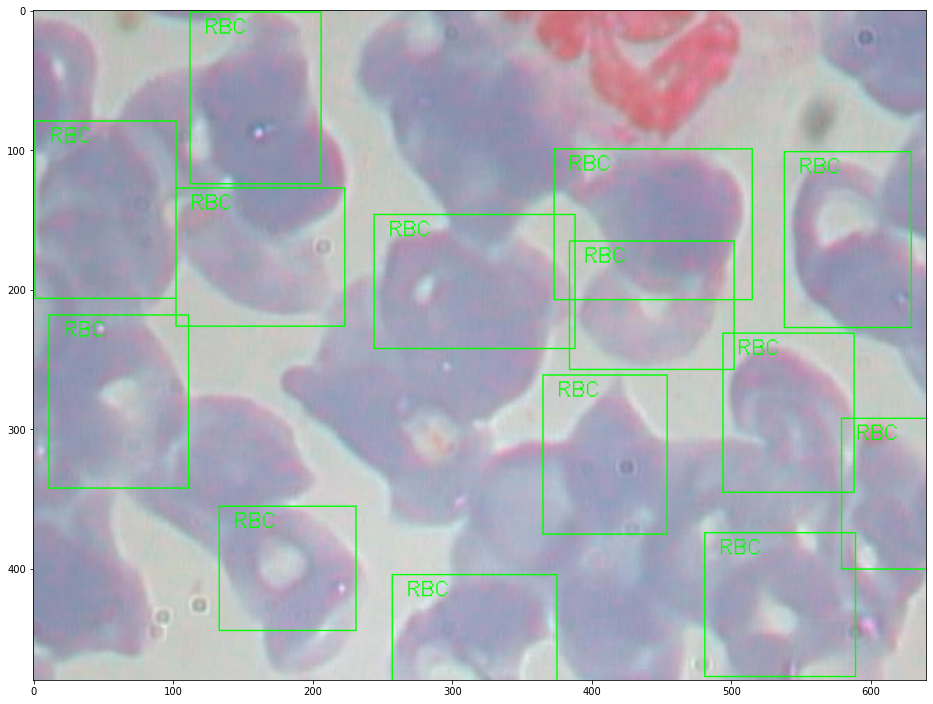

In [ ]:
#check for labling
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                if name[0] == "R":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 255, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                if name[0] == "W":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 0, 255), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                if name[0] == "P":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (255, 0, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()

In [ ]:
df1 = pd.read_csv('dataset-master/labels.csv')
df1 = df1.drop(columns=['Unnamed: 0']).dropna()
df1

,Image,Category
0,0,NEUTROPHIL
1,1,NEUTROPHIL
2,2,NEUTROPHIL
3,3,NEUTROPHIL
4,4,NEUTROPHIL
...,...,...
405,405,NEUTROPHIL
407,407,NEUTROPHIL
408,408,NEUTROPHIL
409,409,NEUTROPHIL


In [ ]:
#reader = csv.reader(open('/dataset-master/labels.csv'))
# skip thev header
y3 = df1[~df1["Category"].str.contains(",", na=False)]['Category']
y3

0      NEUTROPHIL
1      NEUTROPHIL
2      NEUTROPHIL
3      NEUTROPHIL
4      NEUTROPHIL
          ...    
405    NEUTROPHIL
407    NEUTROPHIL
408    NEUTROPHIL
409    NEUTROPHIL
410    EOSINOPHIL
Name: Category, Length: 352, dtype: object

[  3  88  33  21 207]


Text(0, 0.5, 'Number of Cells')

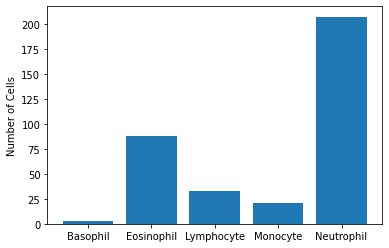

In [ ]:
#print distribution of WBCs in dataset
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Number of Cells')

#Labeling transform to one-hot encoding

In [ ]:
def get_data(folder):
    #    Load the data and labels from the given folder.
    X = []
    y = []
    z = []
    # label- WBC classification / label2- mononuclear/polynuclear classification
    for wbc_type in os.listdir(folder):
        print(wbc_type)
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = cv2.resize(img_file, dsize=(80,60), interpolation=cv2.INTER_CUBIC)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = get_data('dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
print(class1)
print(class2)

  3%|▎         | 72/2483 [00:00<00:03, 719.28it/s]

LYMPHOCYTE


  3%|▎         | 76/2497 [00:00<00:03, 746.43it/s]

EOSINOPHIL


  3%|▎         | 86/2499 [00:00<00:02, 854.93it/s]

NEUTROPHIL


  3%|▎         | 84/2478 [00:00<00:02, 835.96it/s]

MONOCYTE


 13%|█▎        | 78/620 [00:00<00:00, 772.81it/s]

LYMPHOCYTE


 14%|█▎        | 85/623 [00:00<00:00, 842.62it/s]

EOSINOPHIL


 13%|█▎        | 80/624 [00:00<00:00, 792.47it/s]

NEUTROPHIL


 14%|█▎        | 84/620 [00:00<00:00, 826.93it/s]

MONOCYTE


100%|██████████| 620/620 [00:00<00:00, 785.55it/s]


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


# Check for data shape & dimension for training process

In [ ]:
print(y_trainHot.shape) #(9957,5)
print(y_testHot.shape) #(2487,5)
print(z_testHot.shape) #(2487,2)
print(z_trainHot.shape) #(9957,2)

(9957, 5)
(2487, 5)
(2487, 2)
(9957, 2)


In [ ]:
print(X_test.shape) #(2487,60,80,3)
print(X_train.shape) #(9957,60,80,3)

(2487, 60, 80, 3)
(9957, 60, 80, 3)


# Check for data split

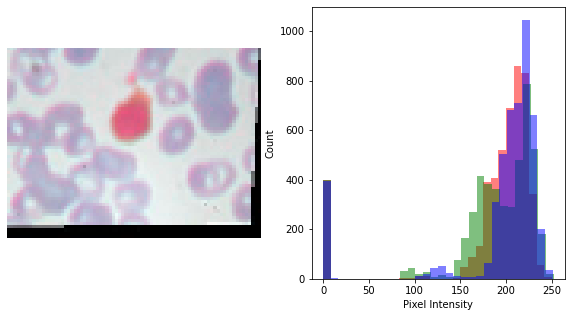

In [ ]:
def plotHistogram(a):
    #Plot histogram of RGB Pixel Intensities
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

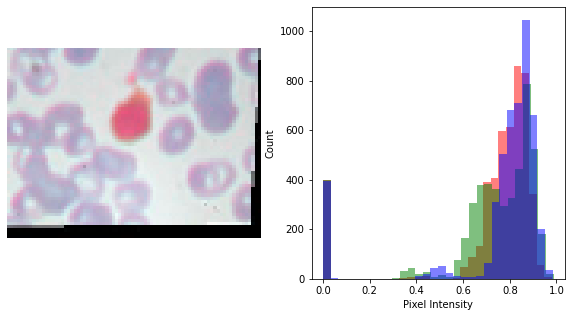

In [ ]:
X_train=np.array(X_train)
X_train=X_train/255.0
X_test=np.array(X_test)
X_test=X_test/255.0
plotHistogram(X_train[1])

# Define a fuction to reduce overfitting due to learning color patterns (for RNN layer)

In [ ]:
def rgb_to_grayscale(input):
    """Average out each pixel across its 3 RGB layers resulting in a grayscale image"""
    return K.mean(input, axis=3)
def rgb_to_grayscale_output_shape(input_shape):
    return input_shape[:-1]

# Plot fuction for showing result

In [ ]:
# Helper Functions  Learning Curves and Confusion Matrix
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
#This function prints and plots the confusion matrix.
#Normalization can be applied by setting `normalize=True`.

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

# Training model(my version)
除此部分外的code都是參考原作者

In [ ]:
def runKerasCNNAugment_2(a,b,c,d,e, epochs, classes):
    
    batch_size = 128
    num_classes = len(b[0])
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=60,80
    input_shape = (img_rows, img_cols, 3)
    input_tensor = Input(shape=input_shape)
    
    #Creating CNN
    modelcnn = Sequential()
    modelcnn.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape,strides=e))
    modelcnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    modelcnn.add(BatchNormalization())
    modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
    modelcnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    modelcnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    modelcnn.add(BatchNormalization())
    modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
    modelcnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    modelcnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    modelcnn.add(BatchNormalization())
    modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
    modelcnn.add(Dropout(0.25))   
    modelcnn.add(Flatten())
    cnn_output = modelcnn(input_tensor)   
    
    # Creating RNN    
    modelrnn = Lambda(rgb_to_grayscale, rgb_to_grayscale_output_shape)(input_tensor)    
    modelrnn = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25, recurrent_dropout=0.25))(modelrnn)
    rnn_output = Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.25))(modelrnn)
    

    # Merging both cnn bottleneck and rnn's output wise element wise multiplication
    merge_layer = concatenate([cnn_output, rnn_output])
    last_process = Dense(128, activation='relu')(merge_layer)
    last_process = Dropout(0.5)(last_process)
    output_tensor = Dense(num_classes, activation='softmax')(last_process)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001,decay=1e-6), metrics=['accuracy'])    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zoom_range=0.1,
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.3, # randomly shift images vertically (fraction of total height)
        shear_range=0.3,      
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32, seed=128), steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = classes
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(classes.values())) 
    plt.show()

# Training model(original version)

In [ ]:
def runKerasCNNAugment(a,b,c,d,e, epochs, classes):
    
    batch_size = 128
    num_classes = len(b[0])
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=60,80
    input_shape = (img_rows, img_cols, 3)
    input_tensor = Input(shape=input_shape)
    
    #Creating CNN
    modelcnn = Sequential()
    modelcnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape,strides=e))
    modelcnn.add(Conv2D(64, (3, 3), activation='relu'))
    modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
    modelcnn.add(Dropout(0.25))
    modelcnn.add(Flatten())
    cnn_output = modelcnn(input_tensor)
    
    # Creating RNN    
    modelrnn = Lambda(rgb_to_grayscale, rgb_to_grayscale_output_shape)(input_tensor)
    modelrnn = LSTM(64, return_sequences=True, dropout=0.25, recurrent_dropout=0.25)(modelrnn)
    rnn_output = LSTM(64, dropout=0.25, recurrent_dropout=0.25)(modelrnn)

    # Merging both cnn bottleneck and rnn's output wise element wise multiplication
    merge_layer = concatenate([cnn_output, rnn_output])
    last_process = Dense(128, activation='relu')(merge_layer)
    last_process = Dropout(0.5)(last_process)
    output_tensor = Dense(num_classes, activation='softmax')(last_process)
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zoom_range=0.1,
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32), steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = classes
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    #plotKerasLearningCurve()
    #plt.show()  
    #plot_learning_curve(history)
    #plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(classes.values())) 
    plt.show()

# Training for WBC cell type classification

In [ ]:
runKerasCNNAugment(X_train,y_trainHot, X_test,y_testHot, 1, 30, class1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
311/311 [==============================] - 223s 609ms/step - loss: 1.5211 - accuracy: 0.2529 - val_loss: 1.4137 - val_accuracy: 0.2437
Epoch 2/30
311/311 [==============================] - 187s 601ms/step - loss: 1.4530 - accuracy: 0.2484 - val_loss: 1.4103 - val_accuracy: 0.2477
Epoch 3/30
311/311 [==============================] - 188s 602ms/step - loss: 1.4503 - accuracy: 0.2519 - val_loss: 1.4120 - val_accuracy: 0.2501
Epoch 4/30
311/311 [==============================] - 186s 599ms/step - loss: 1.4462 - accuracy: 0.2580 - val_loss: 1.4076 - val_accuracy: 0.2630
Epoch 5/30
311/311 [==============================] - 184s 593ms/step - loss: 1.4445 - accuracy: 0.2468 - val_loss: 1.4063 - val_accuracy: 0.2694
Epoch 6/30
311/311 [==============================] - 184s 591ms/step - loss: 1.4438 - accuracy: 0.2526 - val_loss: 1.4052 - val_accuracy: 0.2754
Epoch 7/30
311/311 [==============================] - 184s 591ms/step - loss: 1.4355 - accuracy: 0.2662 - val_loss: 1.4006 -

In [ ]:
runKerasCNNAugment_2(X_train,y_trainHot, X_test,y_testHot, 1, 30, class1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
311/311 [==============================] - 397s 1s/step - loss: 1.8621 - accuracy: 0.3057 - val_loss: 6.1346 - val_accuracy: 0.2505
Epoch 2/30
311/311 [==============================] - 358s 1s/step - loss: 1.1217 - accuracy: 0.4842 - val_loss: 3.3155 - val_accuracy: 0.2795
Epoch 3/30
311/311 [==============================] - 351s 1s/step - loss: 0.8725 - accuracy: 0.6255 - val_loss: 1.6270 - val_accuracy: 0.4978
Epoch 4/30
311/311 [==============================] - 343s 1s/step - loss: 0.7497 - accuracy: 0.6795 - val_loss: 1.0723 - val_accuracy: 0.6224
Epoch 5/30
311/311 [==============================] - 340s 1s/step - loss: 0.6107 - accuracy: 0.7457 - val_loss: 21.0030 - val_accuracy: 0.2674
Epoch 6/30
311/311 [==============================] - 342s 1s/step - loss: 0.5798 - accuracy: 0.7624 - val_loss: 3.1055 - val_accuracy: 0.5199
Epoch 7/30
311/311 [==============================] - 348s 1s/step - loss: 0.5502 - accuracy: 0.7748 - val_loss: 1.3743 - val_accuracy: 0.595

ValueError: ignored

<Figure size 720x360 with 0 Axes>

In [ ]:
runKerasCNNAugment_2(X_train,z_trainHot,X_test,z_testHot,2, 30, class2)